# SIIM ISIC MELANOMA DETECTION - Ensemble(Transfer) Learning

### Ensemble learning is the process by which multiple models, such as classifiers or experts, are strategically generated and combined to solve a particular computational intelligence problem.

### I have trained the model using transfer learning model VGG16 and DenseNet model to predict whether images are Malignant or benign.


In [1]:
'''Installing the required dependencies'''

pip install keras

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\rishv\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
'''Importing the required libraries'''

import numpy as np 
import pandas as pd 
import gc
import json
import math
import cv2
import PIL
from PIL import Image
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
from tensorflow import keras

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Convolution2D,Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import TensorBoard
from keras import applications

In [3]:
'''Loading Train and Test Data'''

train = pd.read_csv("C:/Users/gnana/Downloads/x_test_96.npy/train.csv")
test = pd.read_csv("C:/Users/gnana/Downloads/x_test_96.npy/test.csv")
print("{} images in train set.".format(train.shape[0]))
print("{} images in test set.".format(test.shape[0]))

33126 images in train set.
10982 images in test set.


In [4]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [6]:
'''Mean of the target'''

np.mean(train.target)

0.01762965646320111

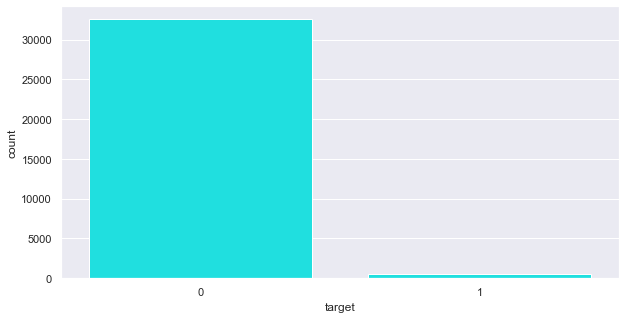

In [7]:
'''Visualizing the counts of the target'''

plt.figure(figsize=(10,5))
sns.countplot(x='target', data=train,
                   order=list(train['target'].value_counts().sort_index().index) ,
                   color='cyan')

In [8]:
''' Counts of the target'''

train['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [9]:
'''Columns Names of the train dataset'''

train.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')

In [10]:
'''Count of target based in sex'''

x=train.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
x.style.background_gradient(cmap='Reds')

,target,sex,benign_malignant
0,0,female,15761
1,0,male,16716
2,1,female,220
3,1,male,364


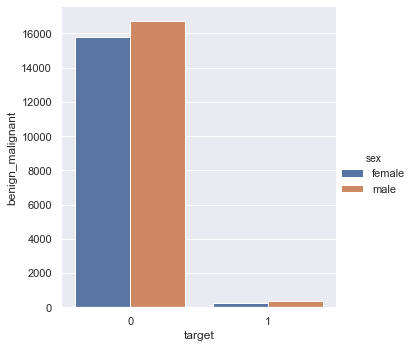

In [11]:
'''Visualizing the count of target based on sex'''

sns.catplot(x='target',y='benign_malignant', hue='sex',data=x,kind='bar')

In [12]:
'''Seperating classes'''

benign = train[train['benign_malignant']=='benign']
malignant = train[train['benign_malignant']=='malignant']

## Training the model

In [14]:
import time

In [15]:
start=time.time()
test_images = np.load('C:/Users/gnana/Downloads/x_test_96.npy/x_test_96.npy')
end=time.time()
print(f"\nTime to load test images: {round(end-start,5)} seconds.")
print('Test_images shape: ',test_images.shape)


Time to load test images: 0.51197 seconds.
Test_images shape:  (10982, 96, 96, 3)


In [16]:
start=time.time()
train_images = np.load('C:/Users/gnana/Downloads/x_test_96.npy/x_train_96.npy')
end=time.time()
print(f"\nTime to load train images: {round(end-start,5)} seconds.")
print('train_images shape: ',train_images.shape)


Time to load train images: 1.58635 seconds.
train_images shape:  (33126, 96, 96, 3)


In [17]:
#target data
train_labels =np.array(train.drop(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis','benign_malignant'],axis=1))
print('Train_labels shape: ',train_labels.shape)

Train_labels shape:  (33126, 1)


In [18]:
'''spliting train data'''

from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(train_images,train_labels,test_size=0.3)

In [19]:
'''Shape of the train and test'''

print('x_train shape: ',x_train.shape)
print('x_val shape: ',x_val.shape)

x_train shape:  (23188, 96, 96, 3)
x_val shape:  (9938, 96, 96, 3)


## Modelling

In [20]:
strategy = tf.distribute.get_strategy()

In [21]:
'''VGG-16 MODEL NO. 1'''

from keras.applications.vgg16 import VGG16

input_shape=(96,96,3)
num_classes=1
tmodel_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
model = Sequential()
model.add(tmodel_base)
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid', name='output_layer'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 512)         2048      
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [22]:
'''DENSENET MODEL NO. 2'''

from tensorflow.keras.applications import DenseNet201
import tensorflow.keras.layers as L

with strategy.scope():
    dnet201 = DenseNet201(
        input_shape=(96,96, 3),
        weights='imagenet',
        include_top=False
    )
    dnet201.trainable = True

    model2 = tf.keras.Sequential([
        dnet201,
        L.GlobalAveragePooling2D(),
        L.Dense(1, activation='sigmoid')
    ])
    model2.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
_________________________________________________________________


In [23]:
'''Fitting Model1'''
batch_size=128
epochs=5

history = model.fit(x_train,
             y_train,
             batch_size=batch_size,
             epochs=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

Epoch 1/5
182/182 [==============================] - 3799s 21s/step - loss: 0.6893 - accuracy: 0.6394 - val_loss: 0.2704 - val_accuracy: 0.9824
Epoch 2/5
182/182 [==============================] - 3516s 19s/step - loss: 0.2549 - accuracy: 0.9451 - val_loss: 0.1982 - val_accuracy: 0.9823
Epoch 3/5
182/182 [==============================] - 3290s 18s/step - loss: 0.1592 - accuracy: 0.9745 - val_loss: 0.4099 - val_accuracy: 0.7934
Epoch 4/5
182/182 [==============================] - 3298s 18s/step - loss: 0.1304 - accuracy: 0.9778 - val_loss: 0.1178 - val_accuracy: 0.9824
Epoch 5/5
182/182 [==============================] - 3469s 19s/step - loss: 0.1226 - accuracy: 0.9776 - val_loss: 0.0911 - val_accuracy: 0.9824


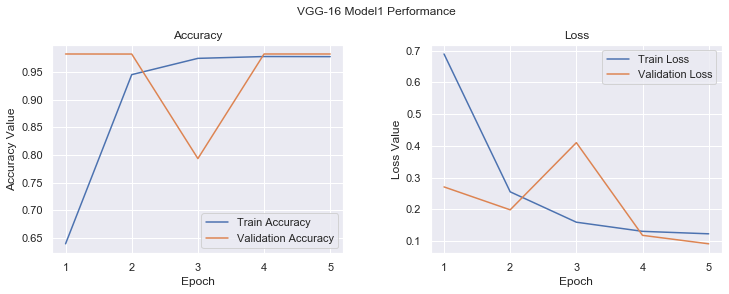

In [22]:
'''Model 1 Performance Visualization'''

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG-16 Model1 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,6))
ax1.plot(epoch_list, history.history['accuracy'] , label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'] , label='Validation Accuracy')
ax1.set_xticks(np.arange(1, 6, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list,history.history['loss'], label='Train Loss')
ax2.plot(epoch_list,history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, 6, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [24]:
'''Fitting Model2'''

batch_size=128
epochs=5

history = model2.fit(x_train,
             y_train,
             batch_size=batch_size,
             epochs=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

Epoch 1/5
182/182 [==============================] - 3293s 18s/step - loss: 0.1275 - accuracy: 0.9628 - val_loss: 0.1253 - val_accuracy: 0.9802
Epoch 2/5
182/182 [==============================] - 3223s 18s/step - loss: 0.0769 - accuracy: 0.9810 - val_loss: 0.0763 - val_accuracy: 0.9824
Epoch 3/5
182/182 [==============================] - 3041s 17s/step - loss: 0.0714 - accuracy: 0.9820 - val_loss: 0.1655 - val_accuracy: 0.9823
Epoch 4/5
182/182 [==============================] - 3059s 17s/step - loss: 0.0745 - accuracy: 0.9820 - val_loss: 925.0889 - val_accuracy: 0.0272
Epoch 5/5
182/182 [==============================] - 3278s 18s/step - loss: 0.0814 - accuracy: 0.9816 - val_loss: 0.8788 - val_accuracy: 0.9824


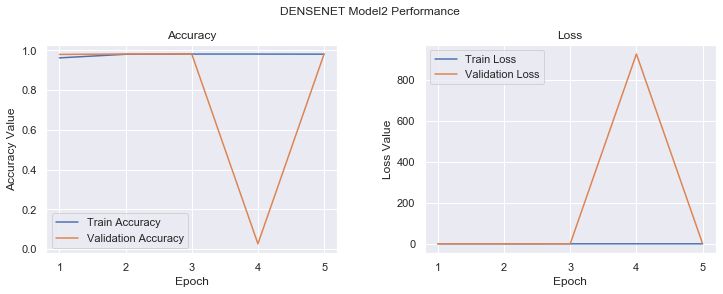

In [24]:
'''Model 2 Performance Visualization'''

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('DENSENET Model2 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,6))
ax1.plot(epoch_list, history.history['accuracy'] , label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'] , label='Validation Accuracy')
ax1.set_xticks(np.arange(1, 6, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list,history.history['loss'], label='Train Loss')
ax2.plot(epoch_list,history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, 6, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [25]:
'''Saving model 1'''

model.save("vgg16.h5")

In [26]:
'''Saving model2'''

model2.save("xception.h5")

In [27]:
''' Loss and accuracy of Model1'''

scores = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.09106143563985825
Test accuracy: 0.982390820980072


In [28]:
''' Loss and accuracy of Model2'''

scores = model2.evaluate(x_val, y_val, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.8787508010864258
Test accuracy: 0.982390820980072


In [29]:
'''Predicting using Model1'''

y_test_prob = model.predict(test_images)
pred_df = pd.DataFrame({'image_name': test['image_name'], 'target': np.concatenate(y_test_prob)})
pred_df.to_csv('submission_vgg.csv',header=True, index=False)
pred_df.head(10)

,image_name,target
0,ISIC_0052060,0.049181
1,ISIC_0052349,0.025696
2,ISIC_0058510,0.024058
3,ISIC_0073313,0.018088
4,ISIC_0073502,0.027797
5,ISIC_0074618,0.034474
6,ISIC_0076801,0.031038
7,ISIC_0077586,0.045804
8,ISIC_0082004,0.035283
9,ISIC_0082785,0.034467


In [30]:
'''Predicting using Model2'''

y_test_prob2 = model2.predict(test_images)
pred_df2 = pd.DataFrame({'image_name': test['image_name'], 'target': np.concatenate(y_test_prob2)})
pred_df2.to_csv('submission_xception.csv',header=True, index=False)
pred_df2.head(10)

,image_name,target
0,ISIC_0052060,0.009682
1,ISIC_0052349,0.006286
2,ISIC_0058510,0.006432
3,ISIC_0073313,0.006461
4,ISIC_0073502,0.015349
5,ISIC_0074618,0.013033
6,ISIC_0076801,0.012930
7,ISIC_0077586,0.026069
8,ISIC_0082004,0.021260
9,ISIC_0082785,0.011665


In [31]:
'''Ensemble Learning'''

en = pd.DataFrame({'image_name':test['image_name'], 'target':(0.3*pred_df['target'] + 0.3*pred_df2['target'])})
en.to_csv('ensemble1.csv',header=True, index=False)
en.head(10)

,image_name,target
0,ISIC_0052060,0.017659
1,ISIC_0052349,0.009595
2,ISIC_0058510,0.009147
3,ISIC_0073313,0.007365
4,ISIC_0073502,0.012944
5,ISIC_0074618,0.014252
6,ISIC_0076801,0.013190
7,ISIC_0077586,0.021562
8,ISIC_0082004,0.016963
9,ISIC_0082785,0.013840
